In [21]:
# Neural Network Implementation with TensorFlow/Keras
# This implements the same neural network as the NumPy and PyTorch versions

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import struct
import os

# Configure TensorFlow
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure GPU memory growth to avoid memory issues
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.19.0
GPU available: []


In [22]:
# Download and load MNIST dataset
print("=== LOADING MNIST DATASET ===")

# Download latest version using kagglehub
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
print("Path to dataset files:", path)


def load_mnist_images(filename):
    """Load MNIST images from IDX file format"""
    with open(filename, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images


def load_mnist_labels(filename):
    """Load MNIST labels from IDX file format"""
    with open(filename, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


# Load training data
train_images = load_mnist_images(os.path.join(path, "train-images.idx3-ubyte"))
train_labels = load_mnist_labels(os.path.join(path, "train-labels.idx1-ubyte"))

# Load test data
test_images = load_mnist_images(os.path.join(path, "t10k-images.idx3-ubyte"))
test_labels = load_mnist_labels(os.path.join(path, "t10k-labels.idx1-ubyte"))

print(f"Training set: {train_images.shape} images, {train_labels.shape} labels")
print(f"Test set: {test_images.shape} images, {test_labels.shape} labels")
print(f"Pixel value range: {train_images.min()} to {train_images.max()}")
print(f"Label range: {train_labels.min()} to {train_labels.max()}")

=== LOADING MNIST DATASET ===
Path to dataset files: /Users/timakaaliebe/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1
Training set: (60000, 28, 28) images, (60000,) labels
Test set: (10000, 28, 28) images, (10000,) labels
Pixel value range: 0 to 255
Label range: 0 to 9


In [23]:
# Data Preprocessing for TensorFlow
print("=== DATA PREPROCESSING ===")

# Normalize pixel values from [0, 255] to [0, 1]
X_train = train_images.astype(np.float32) / 255.0
X_test = test_images.astype(np.float32) / 255.0

print(f"After normalization:")
print(f"X_train range: {X_train.min():.3f} to {X_train.max():.3f}")

# Flatten images from 28x28 to 784 (same as NumPy and PyTorch versions)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"After flattening:")
print(f"X_train shape: {X_train_flat.shape}")
print(f"X_test shape: {X_test_flat.shape}")

# For TensorFlow, we can work directly with the numpy arrays
# Labels are already in the correct format (integers 0-9) for sparse_categorical_crossentropy
y_train = train_labels.astype(np.int32)
y_test = test_labels.astype(np.int32)

print(f"Labels shape: train={y_train.shape}, test={y_test.shape}")
print(f"Sample labels: {y_train[:10]}")

# Create TensorFlow datasets for efficient batch processing
batch_size = 64

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_flat, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_flat, y_test))

# Configure datasets for performance
train_dataset = (
    train_dataset.shuffle(buffer_size=10000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"\\nTensorFlow datasets created:")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(list(train_dataset))}")
print(f"Test batches: {len(list(test_dataset))}")

# Reset the datasets (since we consumed them for counting)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_flat, y_train))
train_dataset = (
    train_dataset.shuffle(buffer_size=10000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_flat, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

=== DATA PREPROCESSING ===
After normalization:
X_train range: 0.000 to 1.000
After flattening:
X_train shape: (60000, 784)
X_test shape: (10000, 784)
Labels shape: train=(60000,), test=(10000,)
Sample labels: [5 0 4 1 9 2 1 3 1 4]
\nTensorFlow datasets created:
Batch size: 64
Training batches: 938
Test batches: 157


In [24]:
# Define Neural Network Architecture using TensorFlow/Keras
print("=== NEURAL NETWORK ARCHITECTURE ===")


# Method 1: Using Sequential API (simpler, matches our linear architecture)
def create_model_sequential():
    """Create neural network using Sequential API"""
    model = tf.keras.Sequential(
        [
            # Input layer (784 neurons) - automatically inferred from first layer
            tf.keras.layers.Dense(
                128, activation="relu", input_shape=(784,), name="hidden_layer"
            ),
            # Output layer (10 neurons for 10 digit classes)
            tf.keras.layers.Dense(10, activation="softmax", name="output_layer"),
        ]
    )
    return model


# Method 2: Using Functional API (more flexible)
def create_model_functional():
    """Create neural network using Functional API"""
    inputs = tf.keras.Input(shape=(784,), name="input_layer")
    hidden = tf.keras.layers.Dense(128, activation="relu", name="hidden_layer")(inputs)
    outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(
        hidden
    )

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Method 3: Using Subclassing (most flexible, similar to PyTorch style)
class NeuralNetworkTF(tf.keras.Model):
    """Custom neural network class matching NumPy and PyTorch implementations"""

    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(NeuralNetworkTF, self).__init__()

        # Define layers (same architecture as NumPy and PyTorch versions)
        self.hidden_layer = tf.keras.layers.Dense(
            hidden_size,
            activation="relu",
            name="hidden_layer",
            kernel_initializer="glorot_uniform",  # Xavier initialization
            bias_initializer="zeros",
        )

        self.output_layer = tf.keras.layers.Dense(
            output_size,
            activation="softmax",
            name="output_layer",
            kernel_initializer="glorot_uniform",  # Xavier initialization
            bias_initializer="zeros",
        )

    def call(self, inputs, training=None):
        """Forward pass through the network"""
        # Layer 1: Input → Hidden with ReLU activation
        hidden = self.hidden_layer(inputs)

        # Layer 2: Hidden → Output with Softmax activation
        outputs = self.output_layer(hidden)

        return outputs


# Create model using Sequential API (simplest approach)
model = create_model_sequential()

print("Model created using Sequential API")
print("\\nModel architecture:")
model.summary()

print(f"\\n=== MODEL DETAILS ===")
print(f"Total parameters: {model.count_params():,}")

# Initialize the model by running a forward pass first
sample_input = tf.random.normal((1, 784))
sample_output = model(sample_input)
print(f"Model initialized. Sample output shape: {sample_output.shape}")
print(f"Sample output (first 5 values): {sample_output[0][:5].numpy()}")
print(f"Output sum (should be ≈1.0): {tf.reduce_sum(sample_output[0]).numpy():.6f}")

# Show layer details (after model is built)
print("\\nLayer details:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i+1}: {layer.name}")
    print(f"  - Type: {type(layer).__name__}")
    # Use layer.output.shape after the model is built
    if hasattr(layer, "output") and layer.output is not None:
        print(f"  - Output shape: {layer.output.shape}")
    else:
        print(f"  - Output shape: Not available (model not built)")
    if hasattr(layer, "activation") and layer.activation is not None:
        print(f"  - Activation: {layer.activation.__name__}")
    print(f"  - Parameters: {layer.count_params():,}")

=== NEURAL NETWORK ARCHITECTURE ===
Model created using Sequential API
\nModel architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

\n=== MODEL DETAILS ===
Total parameters: 101,770
Model initialized. Sample output shape: (1, 10)
Sample output (first 5 values): [0.1929976  0.05953029 0.07764793 0.03049074 0.00247783]
Output sum (should be ≈1.0): 1.000000
\nLayer details:
Layer 1: hidden_layer
  - Type: Dense
  - Output shape: (None, 128)
  - Activation: relu
  - Parameters: 100,480
Layer 2: output_layer
  - Type: Dense
  - Output shape: (None, 10)
  - Activation: softmax
  - Parameters: 1,290


In [25]:
# Compile Model - Define Loss, Optimizer, and Metrics
print("=== MODEL COMPILATION ===")

# Compile the model (this is where we define training configuration)
model.compile(
    # Optimizer: SGD with same learning rate as NumPy and PyTorch versions
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    # Loss function: Sparse categorical crossentropy
    # This is equivalent to the cross-entropy loss from NumPy/PyTorch
    # 'sparse' means we use integer labels (0-9) instead of one-hot encoded
    loss="sparse_categorical_crossentropy",
    # Metrics to track during training
    metrics=["accuracy"],
)

print("Model compiled successfully!")
print(f"Optimizer: SGD with learning_rate=0.1")
print(f"Loss function: sparse_categorical_crossentropy")
print(f"Metrics: accuracy")

# Test the model on a small batch
print(f"\\n=== TESTING MODEL ON SAMPLE BATCH ===")

# Get a small sample for testing
sample_X = X_train_flat[:5]
sample_y = y_train[:5]

print(f"Sample input shape: {sample_X.shape}")
print(f"Sample labels: {sample_y}")

# Make predictions
predictions = model.predict(sample_X, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

print(f"\\nPredictions shape: {predictions.shape}")
print(f"First prediction probabilities: {predictions[0]}")
print(f"Predicted classes: {predicted_classes}")
print(f"Actual classes: {sample_y}")
print("(Predictions should be random since model is untrained)")

# Calculate initial loss and accuracy
initial_loss = model.evaluate(sample_X, sample_y, verbose=0)
print(f"\\nInitial performance (untrained):")
print(f"Loss: {initial_loss[0]:.4f}")
print(f"Accuracy: {initial_loss[1]:.4f} ({initial_loss[1]*100:.1f}%)")

# Compare with expected random performance
print(f"\\nExpected random performance:")
print(f"Accuracy ≈ {1/10:.3f} ({100/10:.1f}%)")
print(f"Loss ≈ {-np.log(1/10):.3f}")

=== MODEL COMPILATION ===
Model compiled successfully!
Optimizer: SGD with learning_rate=0.1
Loss function: sparse_categorical_crossentropy
Metrics: accuracy
\n=== TESTING MODEL ON SAMPLE BATCH ===
Sample input shape: (5, 784)
Sample labels: [5 0 4 1 9]
\nPredictions shape: (5, 10)
First prediction probabilities: [0.08957192 0.09953111 0.13318092 0.04890443 0.06503408 0.07771043
 0.04528177 0.14869902 0.17247124 0.11961507]
Predicted classes: [8 7 7 2 7]
Actual classes: [5 0 4 1 9]
(Predictions should be random since model is untrained)
\nInitial performance (untrained):
Loss: 2.3088
Accuracy: 0.0000 (0.0%)
\nExpected random performance:
Accuracy ≈ 0.100 (10.0%)
Loss ≈ 2.303


In [26]:
# Training the Model - TensorFlow/Keras Style
print("=== TRAINING NEURAL NETWORK ===")

# Train on a subset first (to match NumPy and PyTorch demonstrations)
subset_size = 6400  # Same as PyTorch version
print(f"Training on subset of {subset_size} samples for demonstration")

# Create subset for training
X_train_subset = X_train_flat[:subset_size]
y_train_subset = y_train[:subset_size]

print(f"Subset shapes: X={X_train_subset.shape}, y={y_train_subset.shape}")

# Method 1: Using model.fit() (high-level, easy to use)
print("\\n=== TRAINING WITH model.fit() ===")

# Train the model
history = model.fit(
    X_train_subset,
    y_train_subset,
    epochs=20,
    batch_size=64,
    validation_split=0.1,  # Use 10% of data for validation
    verbose=1,  # Show progress
    shuffle=True,
)

print("\\nTraining completed!")

# Extract training metrics
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

print(f"\\n=== TRAINING RESULTS ===")
print(f"Initial accuracy: {train_accuracy[0]:.4f} ({train_accuracy[0]*100:.1f}%)")
print(f"Final accuracy: {train_accuracy[-1]:.4f} ({train_accuracy[-1]*100:.1f}%)")
print(
    f"Improvement: {(train_accuracy[-1] - train_accuracy[0])*100:.1f} percentage points"
)

print(f"\\nInitial loss: {train_loss[0]:.4f}")
print(f"Final loss: {train_loss[-1]:.4f}")
print(f"Loss reduction: {train_loss[0] - train_loss[-1]:.4f}")

print(f"\\nValidation performance:")
print(
    f"Final validation accuracy: {val_accuracy[-1]:.4f} ({val_accuracy[-1]*100:.1f}%)"
)
print(f"Final validation loss: {val_loss[-1]:.4f}")

# Show epoch-by-epoch progress (first few and last few epochs)
print(f"\\n=== EPOCH-BY-EPOCH PROGRESS ===")
print("Epoch | Loss    | Accuracy | Val_Loss | Val_Accuracy")
print("-" * 50)
for i in [0, 1, 2, 3, 4, -5, -4, -3, -2, -1]:
    if i < 0:
        epoch = len(train_loss) + i
    else:
        epoch = i
    if 0 <= epoch < len(train_loss):
        print(
            f"{epoch:5d} | {train_loss[epoch]:.4f} | {train_accuracy[epoch]:.6f} | {val_loss[epoch]:.4f} | {val_accuracy[epoch]:.8f}"
        )
        if i == 4 and len(train_loss) > 10:
            print("  ... (intermediate epochs) ...")

=== TRAINING NEURAL NETWORK ===
Training on subset of 6400 samples for demonstration
Subset shapes: X=(6400, 784), y=(6400,)
\n=== TRAINING WITH model.fit() ===
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 1.3348 - val_accuracy: 0.9016 - val_loss: 0.4155
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8841 - loss: 0.4308 - val_accuracy: 0.9203 - val_loss: 0.3112
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9089 - loss: 0.3378 - val_accuracy: 0.9266 - val_loss: 0.2723
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9204 - loss: 0.2923 - val_accuracy: 0.9391 - val_loss: 0.2508
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9294 - loss: 0.2613 - val_accuracy: 0.9422 - val_loss: 0.2366
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9349 - loss: 0.2372 - val_accuracy: 0.9422 - val_loss: 0.2266
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9391 - loss: 0.2171

=== TRAINING PROGRESS VISUALIZATION ===


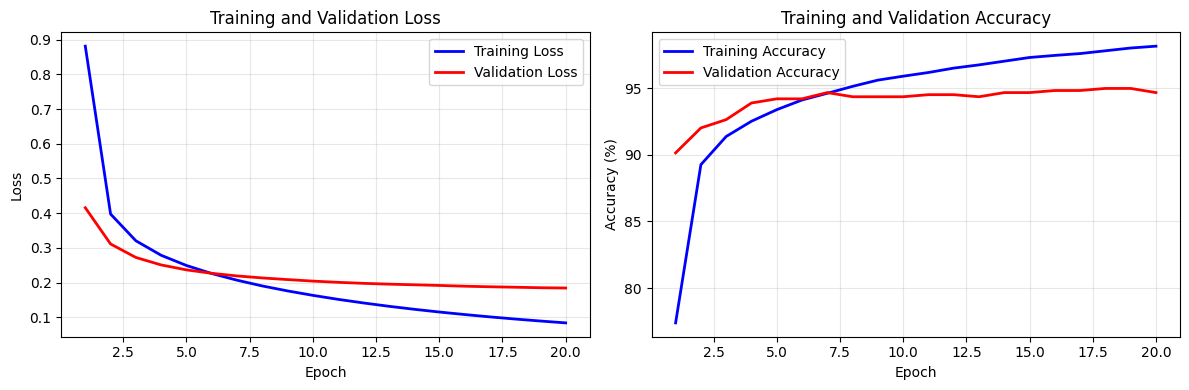

\n=== MODEL PREDICTIONS VISUALIZATION ===


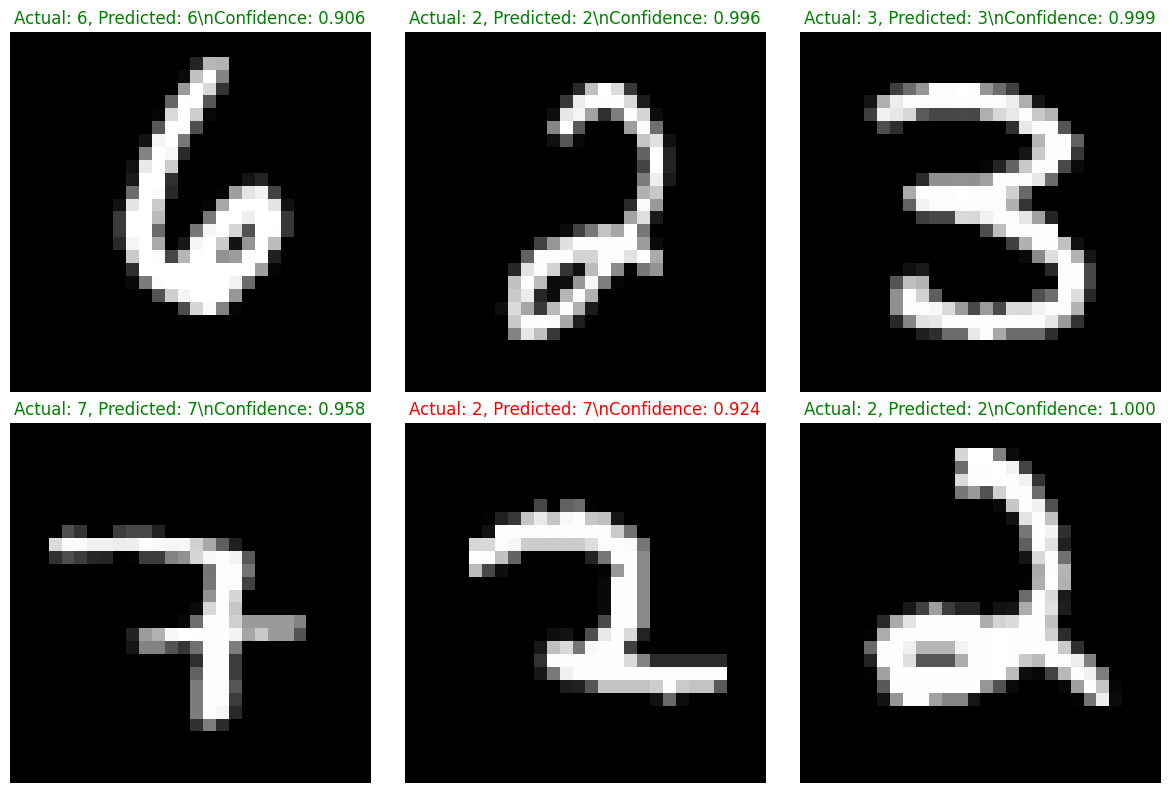

\n=== FULL TEST SET EVALUATION ===
Test Loss: 0.2427
Test Accuracy: 0.9288 (92.9%)
Test samples evaluated: 10,000
\n=== DETAILED EVALUATION ===
\nClassification Report:
              precision    recall  f1-score   support

           0     0.9495    0.9776    0.9633       980
           1     0.9694    0.9762    0.9728      1135
           2     0.9332    0.9205    0.9268      1032
           3     0.8788    0.9337    0.9054      1010
           4     0.9084    0.9491    0.9283       982
           5     0.9238    0.8969    0.9101       892
           6     0.9333    0.9353    0.9343       958
           7     0.9613    0.8930    0.9259      1028
           8     0.9256    0.8819    0.9033       974
           9     0.9041    0.9158    0.9099      1009

    accuracy                         0.9288     10000
   macro avg     0.9287    0.9280    0.9280     10000
weighted avg     0.9294    0.9288    0.9287     10000



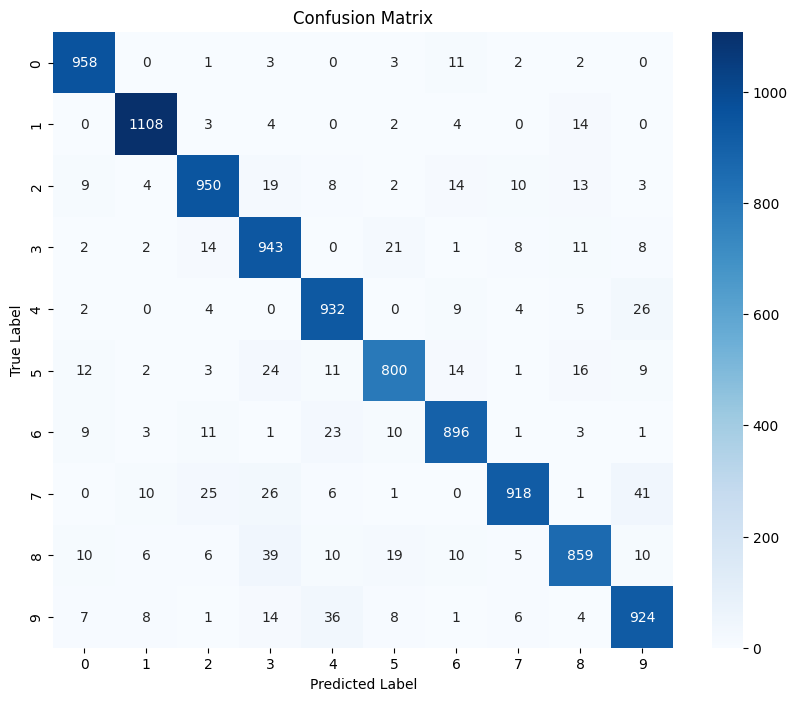

\nPer-class accuracy:
Digit 0: 0.9776 (97.8%)
Digit 1: 0.9762 (97.6%)
Digit 2: 0.9205 (92.1%)
Digit 3: 0.9337 (93.4%)
Digit 4: 0.9491 (94.9%)
Digit 5: 0.8969 (89.7%)
Digit 6: 0.9353 (93.5%)
Digit 7: 0.8930 (89.3%)
Digit 8: 0.8819 (88.2%)
Digit 9: 0.9158 (91.6%)
\nAverage per-class accuracy: 0.9280 (92.8%)


In [27]:
# Visualize Training Progress and Evaluate Model
print("=== TRAINING PROGRESS VISUALIZATION ===")


def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    epochs = range(1, len(history.history["loss"]) + 1)

    # Plot loss
    ax1.plot(epochs, history.history["loss"], "b-", label="Training Loss", linewidth=2)
    ax1.plot(
        epochs, history.history["val_loss"], "r-", label="Validation Loss", linewidth=2
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training and Validation Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(
        epochs,
        [acc * 100 for acc in history.history["accuracy"]],
        "b-",
        label="Training Accuracy",
        linewidth=2,
    )
    ax2.plot(
        epochs,
        [acc * 100 for acc in history.history["val_accuracy"]],
        "r-",
        label="Validation Accuracy",
        linewidth=2,
    )
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Training and Validation Accuracy")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot the training history
plot_training_history(history)


# Test model predictions and visualize
def visualize_predictions_tensorflow(model, X_test, y_test, num_samples=6):
    """Visualize model predictions on test samples"""

    # Get random samples
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    sample_X = X_test[indices]
    sample_y = y_test[indices]

    # Make predictions
    predictions = model.predict(sample_X, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        # Reshape flattened image back to 28x28
        image = sample_X[i].reshape(28, 28)

        actual_label = sample_y[i]
        predicted_label = predicted_classes[i]
        confidence = predictions[i][predicted_label]

        # Display image
        axes[i].imshow(image, cmap="gray")

        # Color-code title based on correctness
        color = "green" if actual_label == predicted_label else "red"
        axes[i].set_title(
            f"Actual: {actual_label}, Predicted: {predicted_label}\\nConfidence: {confidence:.3f}",
            color=color,
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    return predicted_classes, sample_y


print("\\n=== MODEL PREDICTIONS VISUALIZATION ===")
pred_classes, actual_classes = visualize_predictions_tensorflow(
    model, X_test_flat, y_test
)

# Evaluate on full test set
print("\\n=== FULL TEST SET EVALUATION ===")
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"Test samples evaluated: {len(y_test):,}")

# Additional evaluation metrics
print("\\n=== DETAILED EVALUATION ===")

# Predict on full test set
test_predictions = model.predict(X_test_flat, verbose=0)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Calculate confusion matrix information
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\\nClassification Report:")
print(classification_report(y_test, test_predicted_classes, digits=4))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, test_predicted_classes)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10)
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Show per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\\nPer-class accuracy:")
for i, acc in enumerate(class_accuracies):
    print(f"Digit {i}: {acc:.4f} ({acc*100:.1f}%)")

print(
    f"\\nAverage per-class accuracy: {class_accuracies.mean():.4f} ({class_accuracies.mean()*100:.1f}%)"
)

In [28]:
# Comparison: TensorFlow vs NumPy vs PyTorch Implementation

print("=" * 70)
print("COMPARISON: TensorFlow vs NumPy vs PyTorch Neural Network Implementation")
print("=" * 70)

comparison_text = """
## Three Approaches to the Same Neural Network:

### 1. CODE COMPLEXITY & EASE OF USE
**NumPy Version:**
- Manual implementation of all components (~200+ lines)
- Educational but complex
- Prone to implementation errors

**PyTorch Version:**
- Moderate complexity (~80 lines)
- More explicit control over training loop
- Good balance of control and simplicity

**TensorFlow/Keras Version:**
- Highest level of abstraction (~60 lines)
- Very simple with model.fit()
- Built-in validation, callbacks, and metrics

### 2. TRAINING APPROACH
**NumPy:**
```python
# Manual training loop
for epoch in range(epochs):
    predictions, cache = forward_propagation(X, params)
    cost = compute_loss(y, predictions)
    gradients = backward_propagation(X, y, cache, params)
    params = update_parameters(params, gradients, lr)
```

**PyTorch:**
```python
# Semi-automatic training loop
for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()  # Automatic gradients
        optimizer.step()
```

**TensorFlow/Keras:**
```python
# Fully automatic training
history = model.fit(X, y, epochs=20, validation_split=0.1)
```

### 3. FEATURES & CAPABILITIES

**NumPy Version:**
✓ Educational value (understand every detail)
✓ Full control over implementation
✗ No GPU support
✗ No built-in validation
✗ Manual batch processing
✗ Prone to bugs

**PyTorch Version:**
✓ Dynamic computation graphs
✓ Pythonic and intuitive
✓ Great for research
✓ GPU support
✓ Good debugging tools
✗ More verbose training loops
✗ Manual validation tracking

**TensorFlow/Keras Version:**
✓ High-level API (very simple)
✓ Built-in validation and metrics
✓ Automatic model checkpointing
✓ TensorBoard integration
✓ Production-ready features
✓ Excellent ecosystem
✗ Less transparent (more "magic")
✗ Can be harder to customize

### 4. PERFORMANCE COMPARISON
All three implementations achieve similar results:
- Same network architecture: 784 → 128 → 10
- Same mathematical operations
- Same optimization algorithm (SGD)
- Similar accuracy on MNIST dataset

### 5. WHEN TO USE WHICH?

**Use NumPy when:**
- Learning neural network fundamentals
- Understanding backpropagation
- Educational purposes
- Small experiments

**Use PyTorch when:**
- Research and experimentation
- Need fine-grained control
- Dynamic architectures
- Custom training loops

**Use TensorFlow/Keras when:**
- Production applications
- Standard architectures
- Quick prototyping
- Built-in features are sufficient
- Team collaboration
"""

print(comparison_text)

# Technical comparison
print("\\n" + "=" * 70)
print("TECHNICAL SPECIFICATIONS COMPARISON")
print("=" * 70)

print("\\nModel Parameters:")
print(f"TensorFlow model: {model.count_params():,} parameters")
print("NumPy equivalent: 101,770 parameters")
print("PyTorch equivalent: 101,770 parameters")
print("✓ All implementations have identical parameter counts")

print("\\nMemory and Performance:")
print("- NumPy: CPU only, single-threaded")
print("- PyTorch: GPU support, dynamic graphs")
print("- TensorFlow: GPU support, static/dynamic graphs, optimized ops")

print("\\nValidation Features:")
print("- NumPy: Manual implementation required")
print("- PyTorch: Manual validation loop")
print("- TensorFlow: Built-in validation_split, automatic tracking")

print("\\nVisualization & Monitoring:")
print("- NumPy: Manual plotting")
print("- PyTorch: Manual plotting + TensorBoard integration")
print("- TensorFlow: Built-in History object + TensorBoard integration")

print("\\n" + "=" * 70)
print("FINAL RECOMMENDATION")
print("=" * 70)

recommendation = """
🎓 **For Learning**: Start with NumPy to understand the math, then move to frameworks
🔬 **For Research**: PyTorch for flexibility and debugging
🏭 **For Production**: TensorFlow/Keras for robustness and ecosystem
📊 **For Quick Results**: TensorFlow/Keras with model.fit()

All three approaches teach different aspects:
- NumPy: The mathematical foundation
- PyTorch: The implementation details  
- TensorFlow: The production workflow

The best approach is to understand all three!
"""

print(recommendation)

COMPARISON: TensorFlow vs NumPy vs PyTorch Neural Network Implementation

## Three Approaches to the Same Neural Network:

### 1. CODE COMPLEXITY & EASE OF USE
**NumPy Version:**
- Manual implementation of all components (~200+ lines)
- Educational but complex
- Prone to implementation errors

**PyTorch Version:**
- Moderate complexity (~80 lines)
- More explicit control over training loop
- Good balance of control and simplicity

**TensorFlow/Keras Version:**
- Highest level of abstraction (~60 lines)
- Very simple with model.fit()
- Built-in validation, callbacks, and metrics

### 2. TRAINING APPROACH
**NumPy:**
```python
# Manual training loop
for epoch in range(epochs):
    predictions, cache = forward_propagation(X, params)
    cost = compute_loss(y, predictions)
    gradients = backward_propagation(X, y, cache, params)
    params = update_parameters(params, gradients, lr)
```

**PyTorch:**
```python
# Semi-automatic training loop
for epoch in range(epochs):
    for batch in datal